# Trabajo Práctico 3
*   Arelis Picado
*   Diego Solís
*   Isaac Vargas

# 1. Optimización de funciones

Para las siguientes funciones:

$$
f_{0}(x, y) = x^{2} + y^{2}
$$

$$
f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2}
$$

$$
f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy
$$

con $x, y \in [-10, 10]$.

Para todos los algoritmos, ejecútelos por $P = 25$ iteraciones e inicialice las soluciones en el rango $x, y \in [-10, 10]$.



In [3]:
# Imported libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
!pip install optuna
import optuna

In [36]:
# Define our functiones
def f_0(x, y):
    """
    Function f_0: f_0(x, y) = x^2 + y^2
    """
    return x**2 + y**2

def f_1(x, y):
    """
    Function f_1:
    f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
    """
    term1 = (1.5 - x + x * y)**2
    term2 = (2.25 - x + x * y**2)**2
    term3 = (2.625 - x + x * y**3)**2
    return term1 + term2 + term3

def f_2(x, y):
    """
    Function f_2: f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy
    """
    return 0.26 * (x**2 + y**2) - 0.48 * x * y

functions = [f_0, f_1, f_2]

latex_functions = [
    r'$f_0(x, y) = x^2 + y^2$',
    r'$f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$',
    r'$f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$'
]

Creamos un estudio para optimizar usando Optuna

In [37]:
def run_study(optimizer_func, func, eq, n_trials=50, verbose=False):
    """
    Runs an optimization study using a given optimizer function and objective function.

    Parameters:
    - optimizer_func: The optimization function to be used (e.g., RMSprop, Gradient Descent).
    - func: The function to minimize (f_0, f_1, f_2).
    - eq: The equation in LaTeX form for display purposes.
    - n_trials: Number of trials to run for hyperparameter tuning (default is 50).

    Returns:
    - The Optuna study object containing the optimization results.
    """
    if verbose == False:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    print(f"\nOptimizing hyperparameters for {eq} using {optimizer_func.__name__}...")

    # Create a study
    study = optuna.create_study(direction='minimize')

    # Optimize the objective function using the specified optimizer
    study.optimize(lambda trial: optimizer_func(trial, func), n_trials=n_trials)

    return study


def plot_study(func_name: str, losses: list, best_params: dict , best_value: float, eq: str, save: bool = False) -> None:
    """
    Plots the learning curve of the optimization process and displays best hyperparameters and loss.
    """
    print(f"Best hyperparameters for {func_name}: {best_params}")
    print(f"Best loss for {func_name}: {best_value}")

    # Create figure with a light gray facecolor
    fig, ax = plt.subplots(figsize=(10, 6))

    # Change the background color of the plot area (axes)
    ax.set_facecolor('#f7f7fc')  # light lavender color for plot area background

    # Plot the learning curve with a smooth line
    ax.plot(range(1, len(losses) + 1), losses, color='#494980', linewidth=2, label=f'{func_name} loss')

    # Highlight the best value (orange point)
    ax.scatter(len(losses), best_value, color='#fca349', zorder=5, s=100, label=f'Best Loss: {best_value:.4e}')

    # Add grid with lighter color
    ax.grid(True, linestyle='--', alpha=0.3)

    # Title and labels with modern font
    ax.set_title(f'Learning Curve for {eq}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    # Place the legend inside the plot in the upper right corner
    ax.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white')

    # Set ticks styling
    ax.tick_params(axis='both', labelsize=12)

    # Tight layout for clean spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Optionally save the figure as a high-resolution PNG file
    if save:
        plt.savefig(f'{func_name}_learning_curve.png', dpi=300, bbox_inches='tight')

Gráfica del proceso de optimización para diferentes estudios y su línea de aprendizaje.

In [39]:
def contour_and_learning(studies):
    # Retrieve the best trial's losses and visited points
    for std, func, eq in zip(studies, functions, latex_functions):
        best_trial = std.best_trial
        losses = best_trial.user_attrs['losses']
        visited_points = best_trial.user_attrs['visited_points']

        # Plot the optimization path and learning curve
        plot_optimization_path(func=func,
                                eq=eq,
                                losses=losses,
                                visited_points=visited_points)

# Ejercicio #1

1. **(20 puntos)** Grafique las funciones usando la función `meshgrid` y `contour`, y distinga si las funciones son convexas o no, los puntos mínimos y las regiones o puntos silla.

**Solución:** La implementación permite elegir si se presenta en log scale o no para poder facilitar las visualizaciones. En este caso, es más sencillo poder ver el comportamiento de las funciones con esta variable activada. También se modifica de `contour` a `contourf` pues esta última ofrece un mejor resultado visual.

In [6]:
def plot_contours(func, func_name, cmap='magma', levels=20, log_scale=False, save=False):
    x = np.linspace(-10, 10, 400)
    y = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(x, y)

    # Evaluate the function for the meshgrid
    Z = func(X, Y)

    # Handle log scale if required
    if log_scale:
        Z = np.log(np.abs(Z) + 1)  # Adding 1 to avoid log(0) issues

    # Create the filled contour plot
    plt.figure(figsize=(12, 9))
    cp = plt.contourf(X, Y, Z, levels=levels, cmap=cmap)

    # Add title and labels
    plt.title(f'Improved Contour Plot for {func_name}')
    plt.xlabel('x')
    plt.ylabel('y')

    # Show color bar
    plt.colorbar(cp)

    # Save
    if save:
        plt.savefig(f'./imgs/improved_contour_plot_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

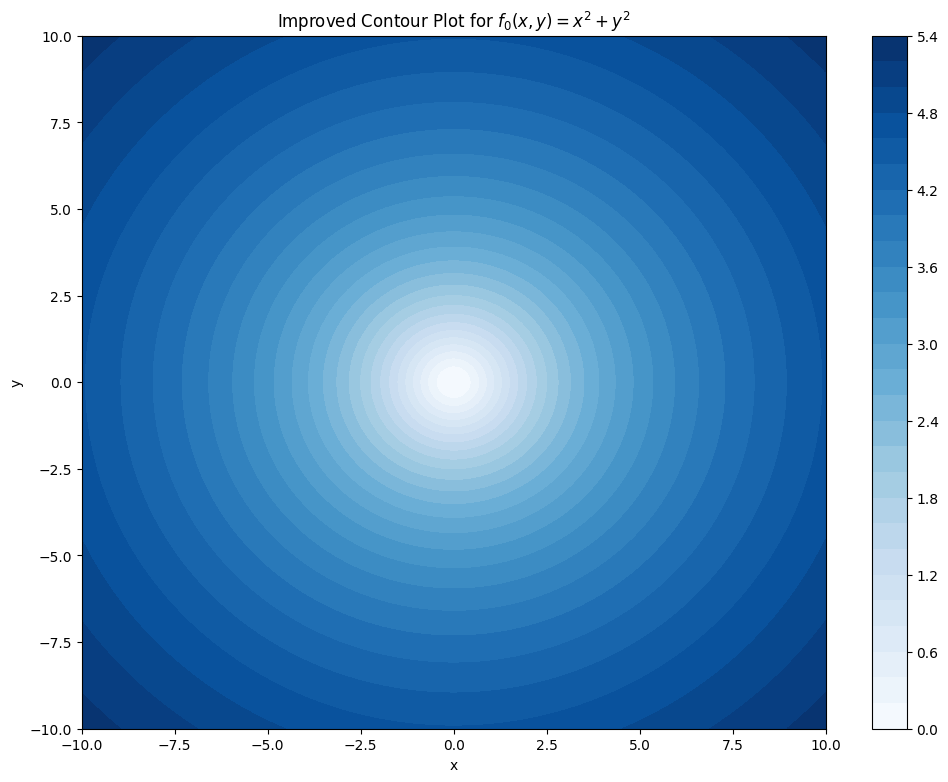

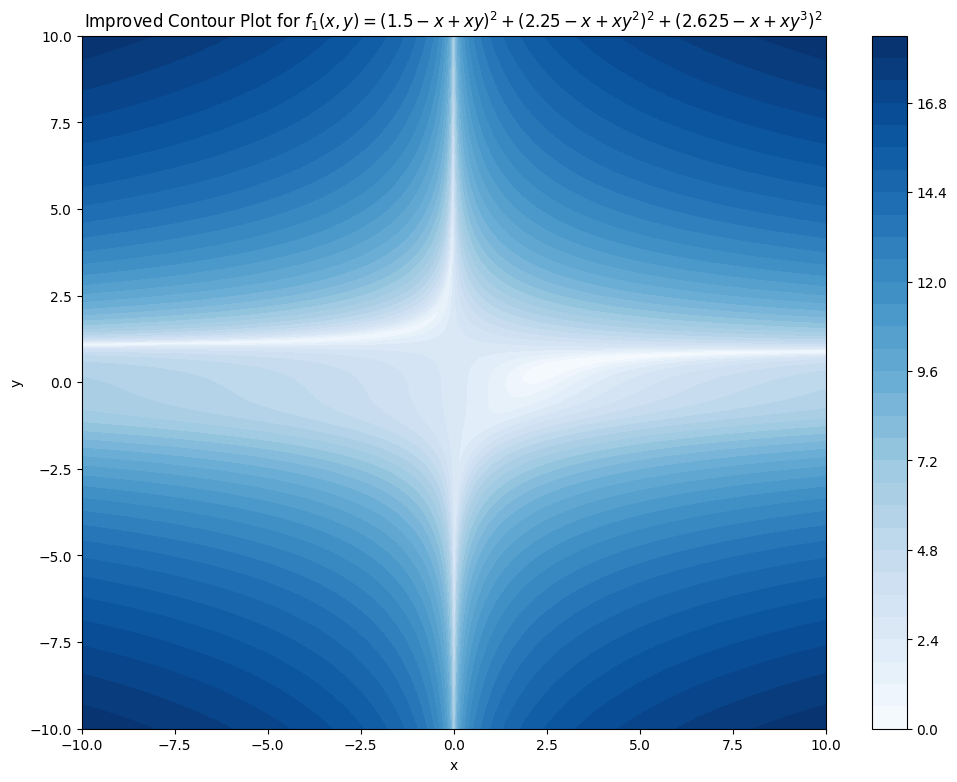

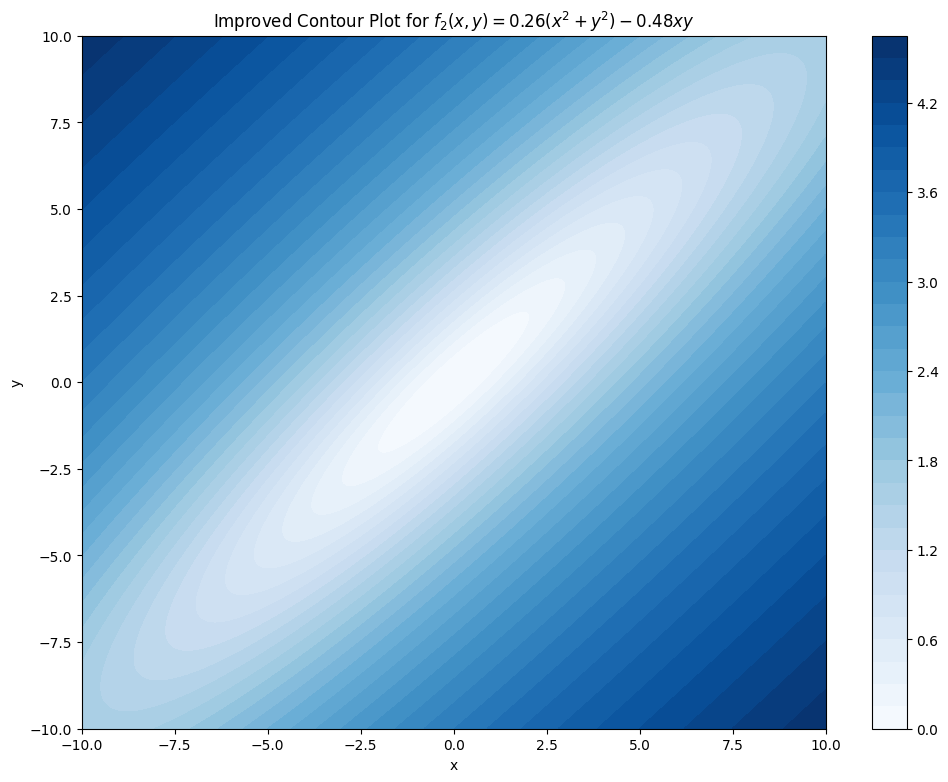

In [7]:
for f, eq in zip(functions, latex_functions):
    plot_contours(f, func_name=eq, levels=30, log_scale=True, save=False, cmap='Blues')

# REVISAR ANTES DE ENVIAR
* La función f_0 es convexa, como se puede ver del plot. Esta función sería, en tres dimensiones, como un bolw
* La función f_1 tiene un punto de silla por los cambios bruscos en el plot de contorno
* La función f_2 también es convexa

**EXTRA:** Con plots de 3D se puede visualizar aún mejor

In [8]:
def plot_3d_surface(func, func_name, cmap='viridis', save=False):
    x = np.linspace(-50, 50, 400)
    y = np.linspace(-50, 50, 400)
    X, Y = np.meshgrid(x, y)

    # Evaluate the function for the meshgrid
    Z = func(X, Y)

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')

    # Add title and labels
    ax.set_title(f'3D Surface Plot for {func_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')

    # Show color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    if save:
        plt.savefig(f'./imgs/plot_3d_surface_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

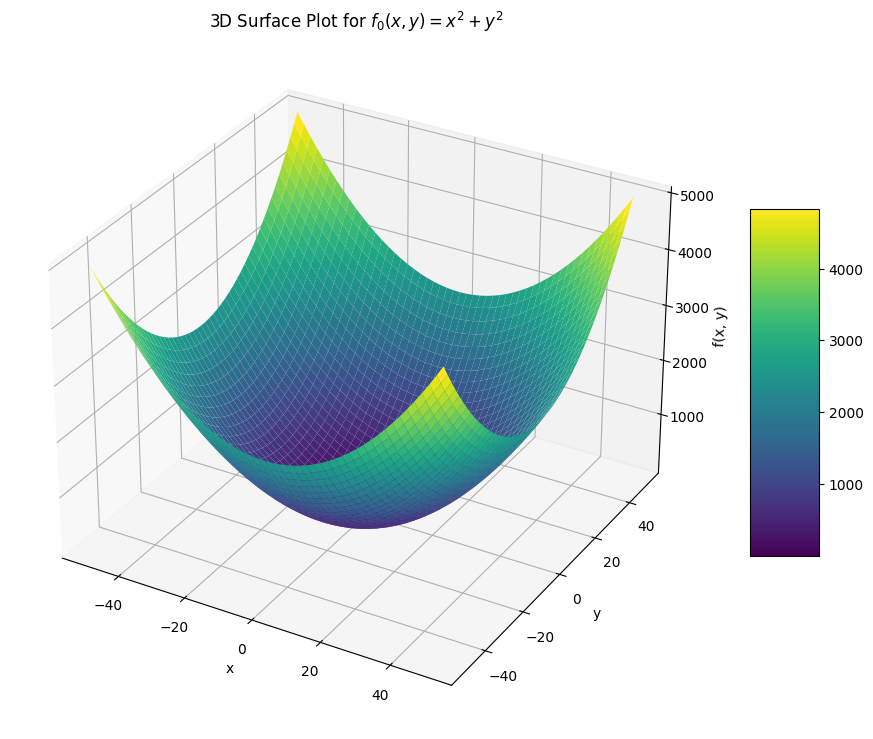

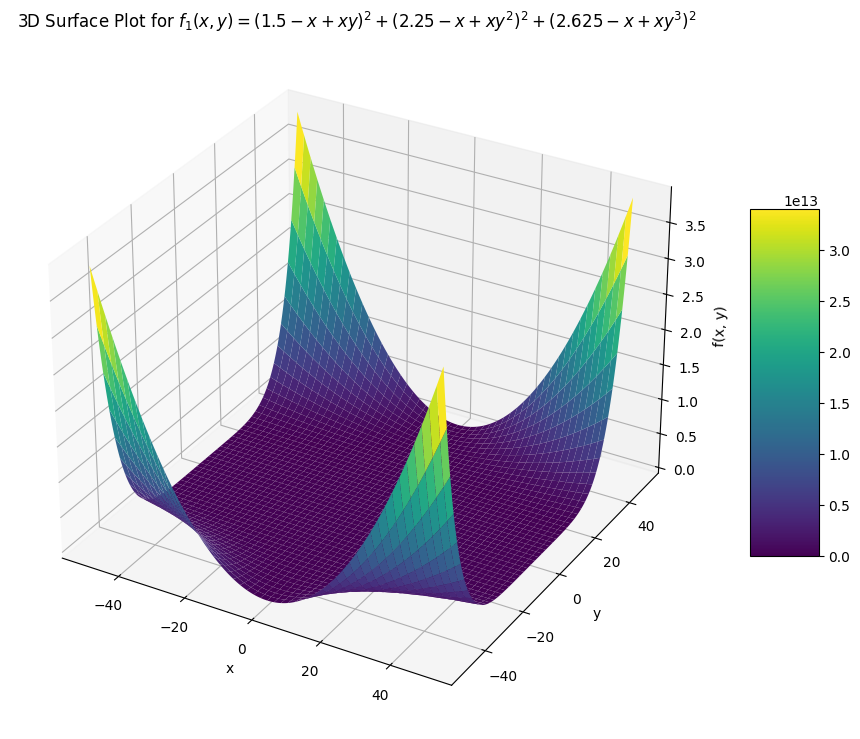

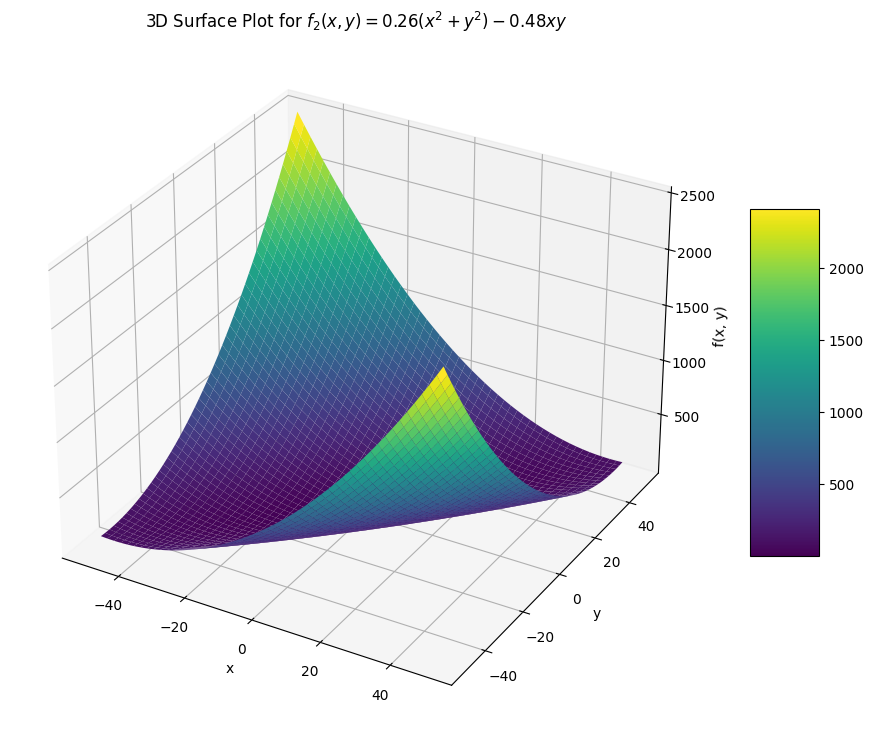

In [9]:
for f, eq in zip(functions, latex_functions):
    plot_3d_surface(f, eq)

#### 2.(40 puntos) Implemente el algoritmo RMSprop para encontrar el punto mínimo en PyTorch de la forma más vectorial posible.

**Solución:** Implementamos de forma manual el RMSprop. El Backpropagation se toma de PyTorch para simplificar el proceso

In [10]:
def RMSprop(trial, func, max_iterations = 25):
    import numpy
    # Suggest hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 0.9, 0.999)
    eps = 1e-8

    # Initialize parameters
    params = torch.randn((2, 1), requires_grad=True)
    avg_sq_grad = torch.zeros_like(params)

    # Record losses for plotting the learning curve
    losses = []
    visited_points = []

    for _ in range(max_iterations):
        if params.grad is not None:
            params.grad.zero_()
        # Compute loss
        loss = func(params[0], params[1])
        # Backpropagation
        loss.backward()
        # Manually update parameters using RMSprop
        with torch.no_grad():
            avg_sq_grad = alpha * avg_sq_grad + (1 - alpha) * params.grad**2
            params -= lr * params.grad / (torch.sqrt(avg_sq_grad) + eps)
        # Keep the loss
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

    # Save losses
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    # Return the final loss value
    return loss.item()


Implemente las siguientes pruebas:

a. **Calibración de Hiperparámetros**
   - Para cada función, calibre los hiperparámetros del algoritmo, mostrando el proceso de calibrado usando las gráficas de aprendizaje, y reporte los mejores valores encontrados.

   1. Realice el proceso de calibración usando un framework como [Optuna](https://optuna.org/) o [Weights and Biases](https://wandb.ai/site). Reporte los mejores valores encontrados.

In [11]:
torch.manual_seed(42)

##### Optimización de $f_{0}(x, y) = x^{2} + y^{2}$

In [12]:
RMS_opt = []

study_results_f_0 = run_study(RMSprop, functions[0], latex_functions[0])
RMS_opt.append(study_results_f_0)


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using RMSprop...


Best hyperparameters for f_0: {'lr': 0.06472120923179182, 'alpha': 0.9919329124417406}
Best loss for f_0: 1.222632910123403e-41


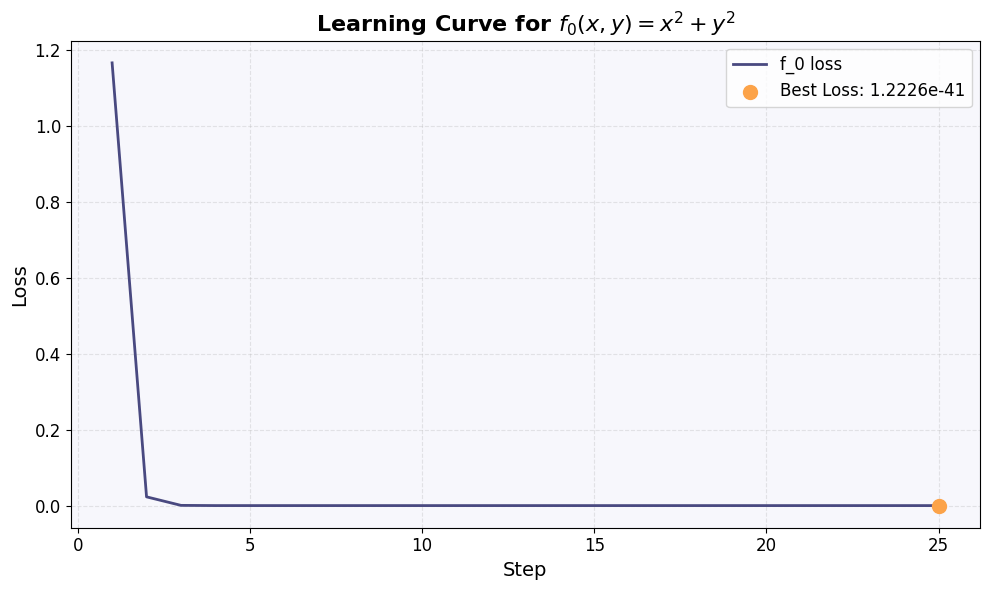

In [13]:
plot_study(func_name=functions[0].__name__,
           losses= study_results_f_0.best_trial.user_attrs['losses'],
           best_params= study_results_f_0.best_params,
           best_value= study_results_f_0.best_value,
           eq =latex_functions[0])

##### Optimización de $ f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2} $

In [14]:
study_results_f_1 = run_study(RMSprop, functions[1], latex_functions[1])
RMS_opt.append(study_results_f_1)



Optimizing hyperparameters for $f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$ using RMSprop...


Best hyperparameters for f_1: {'lr': 0.09927458943088865, 'alpha': 0.9959056629510327}
Best loss for f_1: 0.03265675529837608


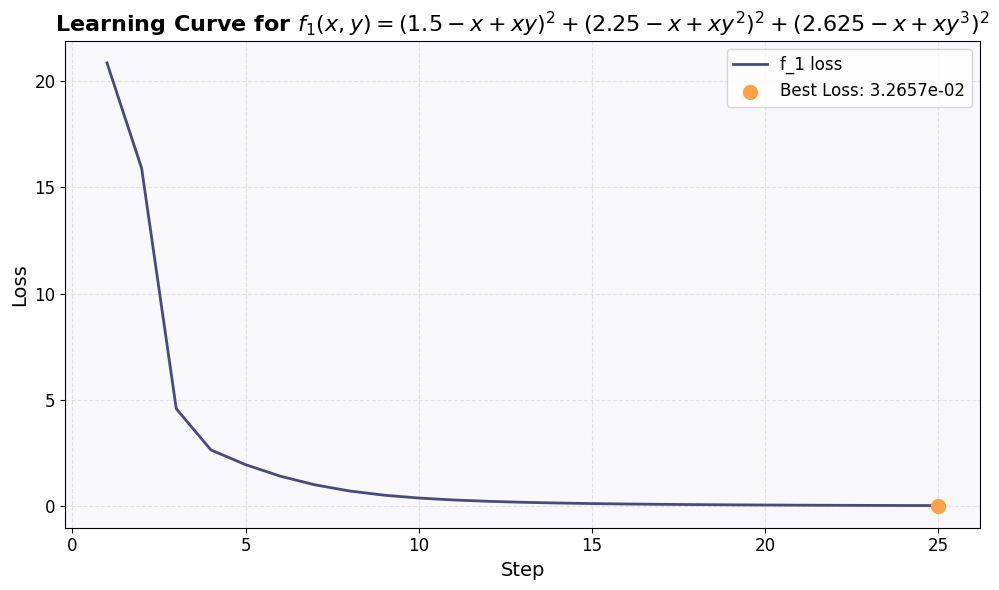

In [15]:
plot_study(func_name=functions[1].__name__,
           losses= study_results_f_1.best_trial.user_attrs['losses'],
           best_params= study_results_f_1.best_params,
           best_value= study_results_f_1.best_value,
           eq =latex_functions[1])

##### Optimización de $f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy$


In [16]:
study_results_f_2 = run_study(RMSprop, functions[2], latex_functions[2])
RMS_opt.append(study_results_f_2)


Optimizing hyperparameters for $f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$ using RMSprop...


Best hyperparameters for f_2: {'lr': 0.08878008390704044, 'alpha': 0.9784738405981358}
Best loss for f_2: 1.2587888704729266e-06


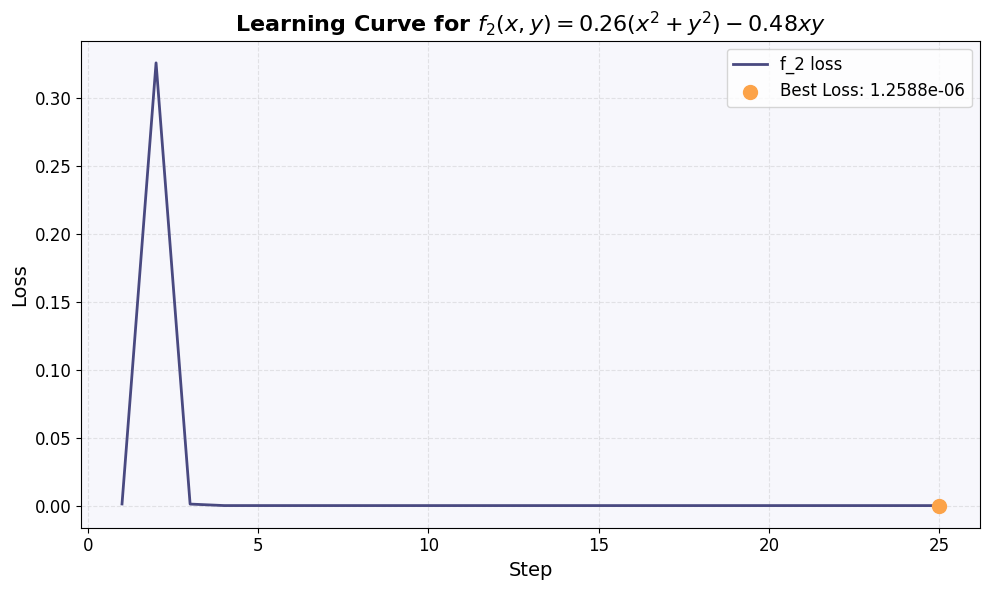

In [17]:
plot_study(func_name=functions[2].__name__,
           losses=study_results_f_2.best_trial.user_attrs['losses'],
           best_params=study_results_f_2.best_params,
           best_value=study_results_f_2.best_value,
           eq =latex_functions[2])

b. Realice lo anterior para el algoritmo del descenso del gradiente.



In [18]:
def gradient_descent(trial, func):
    """
    Implements Gradient Descent to minimize the given function.

    Parameters:
    - trial: The Optuna trial object to suggest hyperparameters.
    - func: The function to minimize (like f_0, f_1, f_2).

    Returns:
    - Final loss value after optimization.
    """

    # Suggest hyperparameters to tune (only the learning rate in Gradient Descent)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)

    # Initialize parameters (2 parameters: x and y)
    params = torch.randn((2, 1), requires_grad=True)

    # Record losses for plotting the learning curve
    losses = []
    visited_points = []

    max_iterations = 25  # As per your instructions
    for _ in range(max_iterations):
        if params.grad is not None:
            params.grad.zero_()

        # Compute loss (your function needs to accept torch tensors)
        loss = func(params[0], params[1])

        # Backward pass to compute gradients
        loss.backward()

        # Manually update parameters using Gradient Descent
        with torch.no_grad():
            params -= lr * params.grad  # Basic gradient descent update rule

        # Record the loss for this iteration
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

    # Save losses for later visualization
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    # Return the final loss value
    return loss.item()


In [19]:
grad_opt = []

##### Optimización de $f_{0}(x, y) = x^{2} + y^{2}$
###### with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_0: {'lr': 0.09914472547108845}
Best loss for f_0: 1.1829035429400392e-05


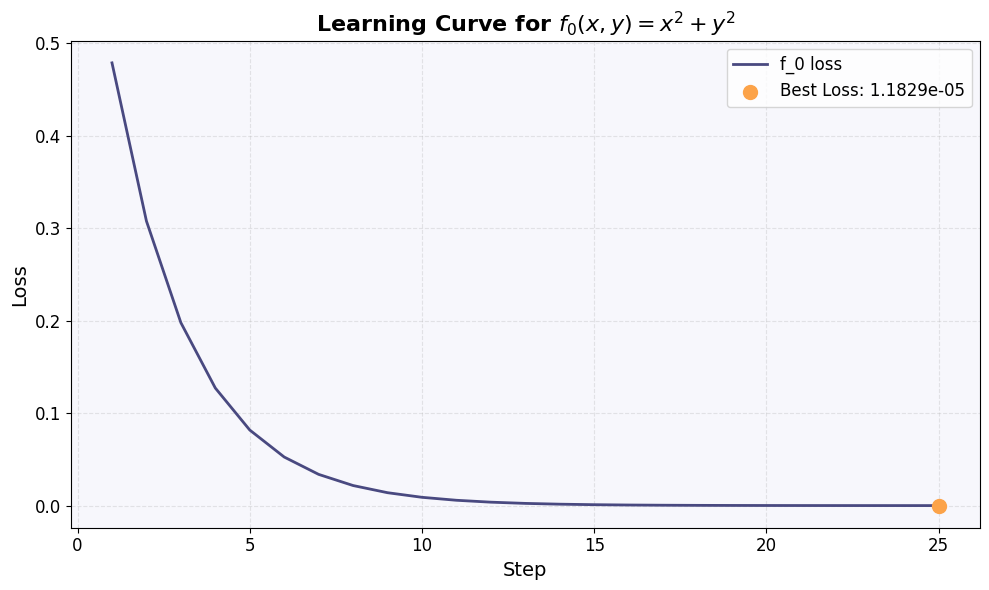

In [20]:
study_results_g_f_0 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_0)
plot_study(func_name=functions[0].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[0])

##### Optimización de $ f_{1}(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x + xy^{3})^{2} $
###### with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_1: {'lr': 0.09914472547108845}
Best loss for f_1: 1.1829035429400392e-05


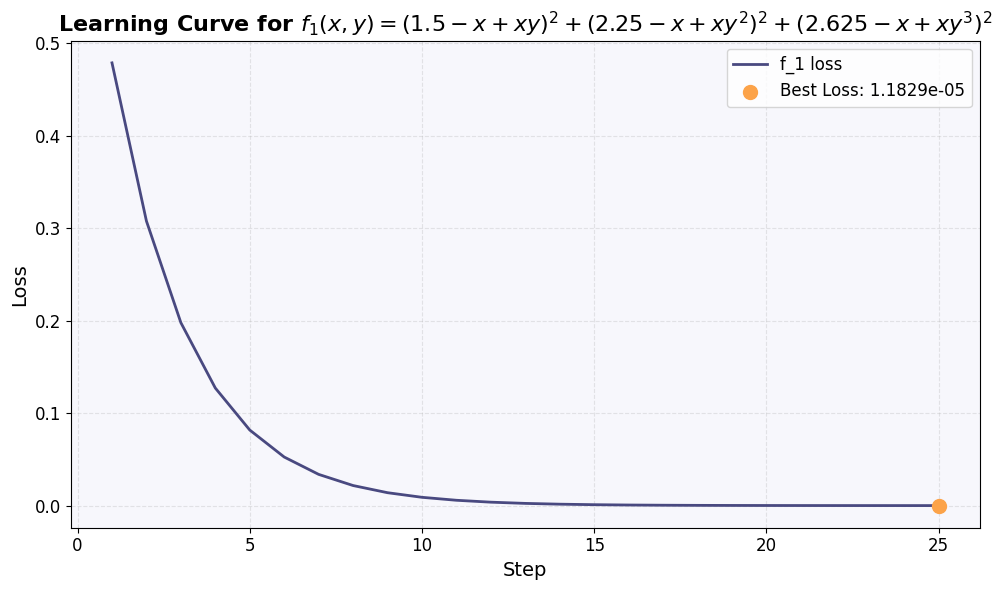

In [21]:
study_results_g_f_1 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_1)
plot_study(func_name=functions[1].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[1])

##### Optimización de $f_{2}(x, y) = 0.26(x^{2} + y^{2}) - 0.48xy$
###### with gradient descent


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using gradient_descent...
Best hyperparameters for f_2: {'lr': 0.09914472547108845}
Best loss for f_2: 1.1829035429400392e-05


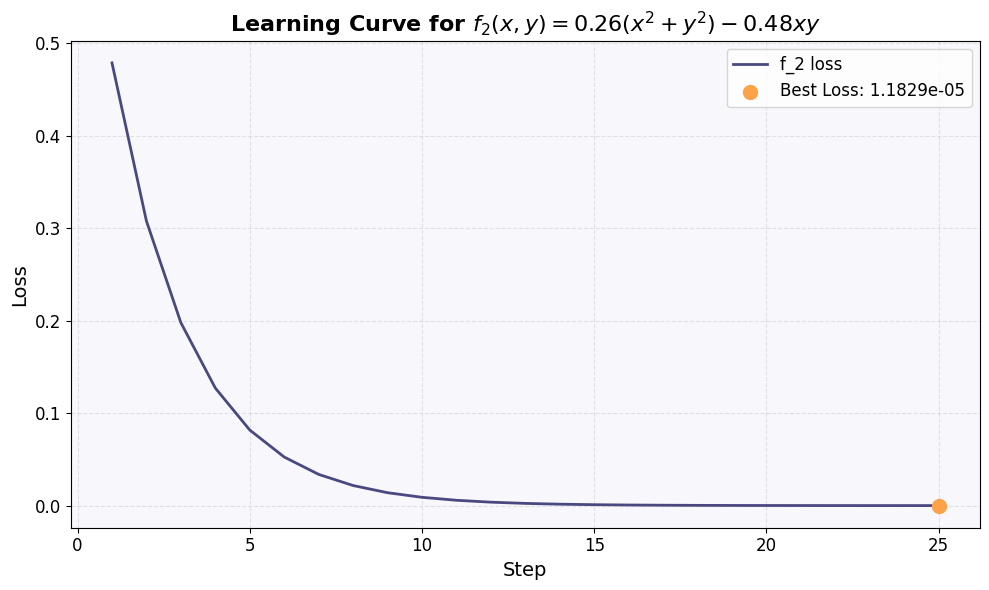

In [22]:
study_results_g_f_2 = run_study(gradient_descent, functions[0], latex_functions[0])
grad_opt.append(study_results_g_f_2)
plot_study(func_name=functions[2].__name__,
           losses=study_results_g_f_0.best_trial.user_attrs['losses'],
           best_params=study_results_g_f_0.best_params,
           best_value=study_results_g_f_0.best_value,
           eq =latex_functions[2])

c. **Comparación RMSprop y Descenso del Gradiente**
   - Explique por qué el algoritmo RMSprop es más efectivo en evitar atascarse en puntos silla que el algoritmo del descenso del gradiente.



**Respuesta:** El RMSprop es un algoritmo adaptativo que permite ajustar su taza de aprendizaje basado en lo que sucedido recientemente en el algoritmo. Esto le permite queda atrapado en oscilaciones, puntos de silla u otras anomalias a las que el descenso del gradiente regular es más suceptible. El RMSprop mantiene una media movil de los gradientes recientes y escala los gradientes futuros basados en este parametro. La concecuencia principal de esto es que no hay aprendizajes ni muy grandes ni muy pequeños. Todos los eventos de aprendizaje se mantienenen relativamente uniformes. Un factor importante a mencionar es que, si bien usa lo que sucedió recientemente, no mantiene todo el pasado. Solo se adapta en una ventana reciente aumentando la estabilidad local del aprendizaje.

d. **Ejecución de Algoritmos**

   1. Ejecute el algoritmo 10 veces y documente en una tabla la cantidad de iteraciones para converger al o los puntos mínimos (indique si hubo convergencia).

   2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.

# Ejercicio #2

**(40 puntos)** Implemente el algoritmo del RMS prop. para encontrar el punto mínimo en PyTorch, de la forma más vectorial posible. Implemente las siguientes pruebas.

a) Para cada función, calibre los hiperparámetros del algoritmo, mostrando el proceso de calibrado usando las gráficas de aprendizaje, y reporte los mejores valores encontrados.

1. Realice el proceso de calibración usando un framework como optuna https://optuna.org/ o weights and biases https://wandb.ai/site. Reporte los mejores valores encontrados.

b) Realice lo anterior para el algoritmo del descenso del gradiente.

c) ¿Por qué el algoritmo RMS prop es más efectivo en evitar atascarse en puntos silla que el algoritmo del descenso del gradiente?

d) Para los mejores valores encontrados, en cada función, por un máximo de 25 iteraciones (para el algoritmo del descenso del gradiente, y RMS prop):

1. Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos mínimos (indique si convergió).
        
2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.

e) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia más rápida) para cada función. Para ello, use el gráfico de las curvas de nivel. Además, para tales corridas, grafique la curva de aprendizaje.

In [23]:
def plot_optimization_path(func, eq, losses, visited_points, save=False):
    """
    Visualizes the points visited by the optimizer during its run, overlaid on a contour plot.

    Parameters:
    - func: The function being optimized.
    - eq: The equation in LaTeX form for display purposes.
    - losses: List of loss values over iterations (for the learning curve).
    - visited_points: List of tuples (x, y) representing points visited by the optimizer.
    """
    func_name = func.__name__

    x = np.linspace(-10, 10, 400)
    y = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), facecolor='#f7f7fc')

    # Plot the contour map of the function
    cp = ax[0].contourf(X, Y, Z, levels=50, cmap='Blues')
    ax[0].clabel(cp, inline=True, fontsize=8)

    # Plot the path of the optimizer (points visited)
    visited_points = np.array(visited_points)
    ax[0].plot(visited_points[:, 0], visited_points[:, 1], color='#fca349', marker='o', label='Optimization Path')

    # Annotate and format the plot
    ax[0].set_title(f'Optimization Path for {func_name}', fontsize=14)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].grid(True, linestyle='--', alpha=0.3)
    ax[0].legend()

    # Plot the learning curve (loss vs. iteration)
    ax[1].set_facecolor('#f7f7fc')
    ax[1].plot(range(1, len(losses) + 1), losses, color='#494980', linewidth=2, label=f'{func_name} Loss')
    ax[1].scatter(len(losses), losses[-1], color='#fca349', zorder=5, s=100, label=f'Final Loss: {losses[-1]:.4e}')

    # Annotate and format the learning curve plot
    ax[1].set_title(f'Learning Curve for {eq}', fontsize=14)
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')
    ax[1].grid(True, linestyle='--', alpha=0.3)
    ax[1].legend()

    # Tight layout for better spacing
    plt.tight_layout()

    if save:
        plt.savefig(f'./imgs/plot_optimization_path_{func.__name__}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


In [25]:
# Contour plots and learning curve with optimization path for RMSprop
contour_and_learning(RMS_opt)

NameError: name 'function' is not defined

In [ ]:
# Contour plots and learning curve with optimization path for Gradient Descent
contour_and_learning(grad_opt)

f) Realice una comparativa entre el algoritmo del descenso del gradiente y el algoritmo RMS prop. según los resultados obtenidos.


f. **Comparativa Final**
   - Realice una comparativa entre el algoritmo del descenso del gradiente y el algoritmo RMSprop según los resultados obtenidos.

# Ejercicio #3

**(30 puntos)** Implemente el algoritmo de simulated annealing en PyTorch, de la forma más vectorial posible.

In [40]:
def simulated_annealing(trial, func, max_iterations=25):
    """
    Implements the Simulated Annealing algorithm for optimization in PyTorch.

    Parameters:
    - trial: The Optuna trial object to suggest hyperparameters.
    - func: The function to minimize (like f_0, f_1, f_2).
    - max_iterations: The maximum number of iterations to run the annealing process.

    Returns:
    - Final loss value after optimization.
    """

    # Suggest hyperparameters to tune
    initial_temp = trial.suggest_float('initial_temp', 10.0, 1000.0, log=True)
    alpha = trial.suggest_float('alpha', 0.8, 0.99)  # Cooling rate

    # Initialize parameters (2 parameters: x and y)
    params = torch.randn((2, 1), requires_grad=True)
    best_params = params.clone()

    # Calculate initial loss
    loss = func(params[0], params[1])
    best_loss = loss.item()

    # Initialize temperature
    T = initial_temp

    # Record losses and visited points for plotting the learning curve
    losses = []
    visited_points = []

    for _ in range(max_iterations):
        # Store current parameters and loss
        losses.append(loss.item())
        visited_points.append([params[0].item(), params[1].item()])

        # Generate new candidate by adding small random noise
        candidate_params = params + torch.randn_like(params) * T

        # Compute loss for the new candidate
        new_loss = func(candidate_params[0], candidate_params[1])

        # Decide whether to accept the new solution
        delta_loss = new_loss.item() - loss.item()

        if delta_loss < 0 or torch.rand(1).item() < torch.exp(-torch.tensor(delta_loss) / torch.tensor(T)):
            # Accept the candidate solution
            params = candidate_params.clone()
            loss = new_loss

            # Update best solution
            if loss.item() < best_loss:
                best_params = params.clone()
                best_loss = loss.item()

        # Cool down the temperature
        T *= alpha

    # Save losses and visited points for later visualization
    trial.set_user_attr('losses', losses)
    trial.set_user_attr('visited_points', visited_points)

    return best_loss

a) Realice un proceso de calibración de sus hiperparámetros y reporte los mejores valores encontrados, usando como evidencia las gráficas de aprendizaje de los mejores hiperparámetros encontrados.

In [41]:
sa_opt = []

for func, eq in zip(functions, latex_functions):
    sa_opt.append(run_study(simulated_annealing, func, eq))


Optimizing hyperparameters for $f_0(x, y) = x^2 + y^2$ using simulated_annealing...

Optimizing hyperparameters for $f_1(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2$ using simulated_annealing...

Optimizing hyperparameters for $f_2(x, y) = 0.26(x^2 + y^2) - 0.48xy$ using simulated_annealing...


#### Contour plots and learning curve with optimization path for Simulated Annealing

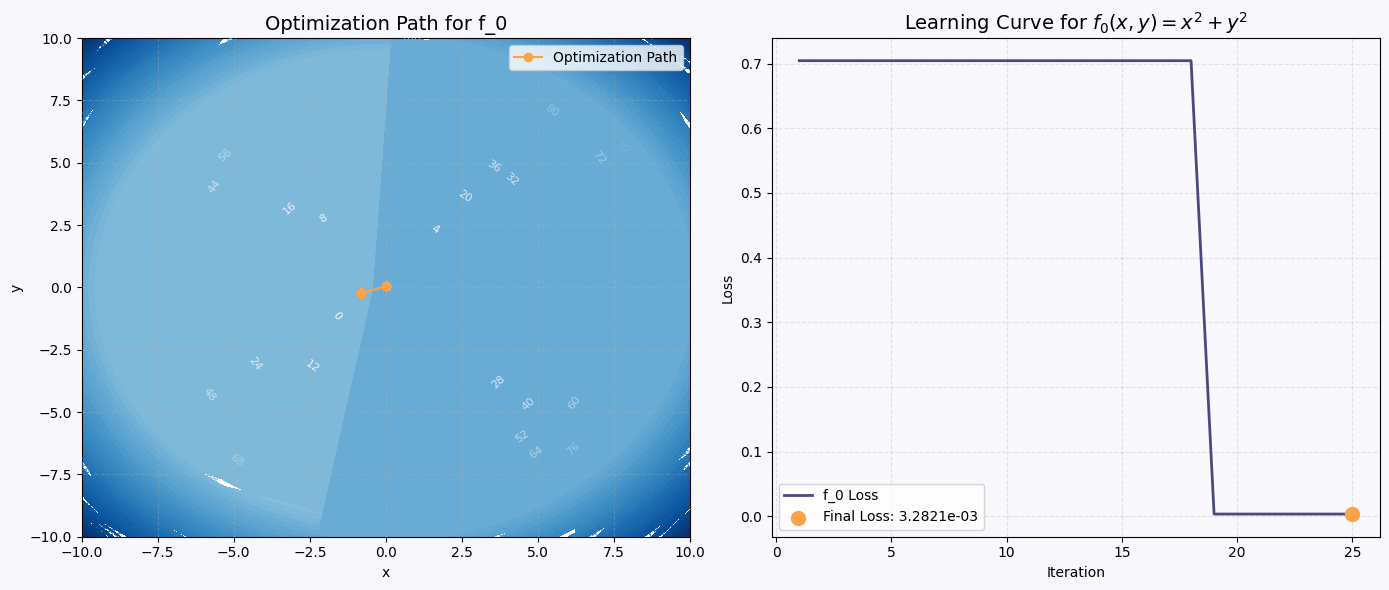

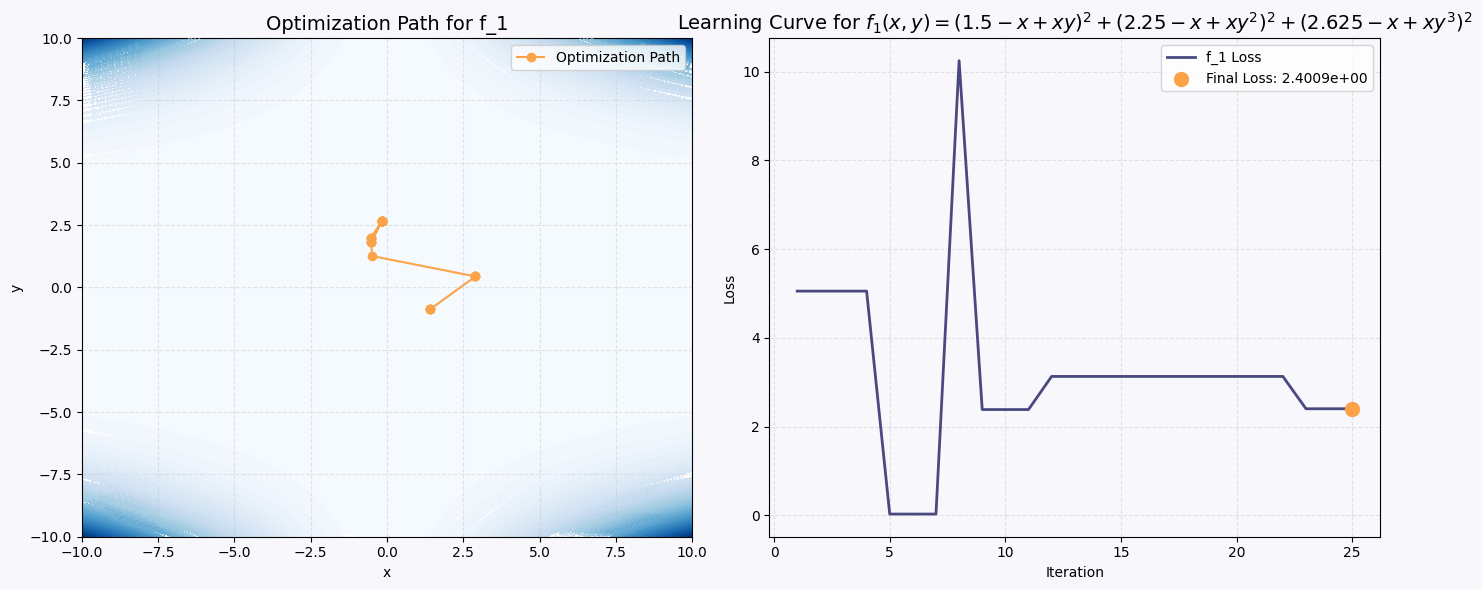

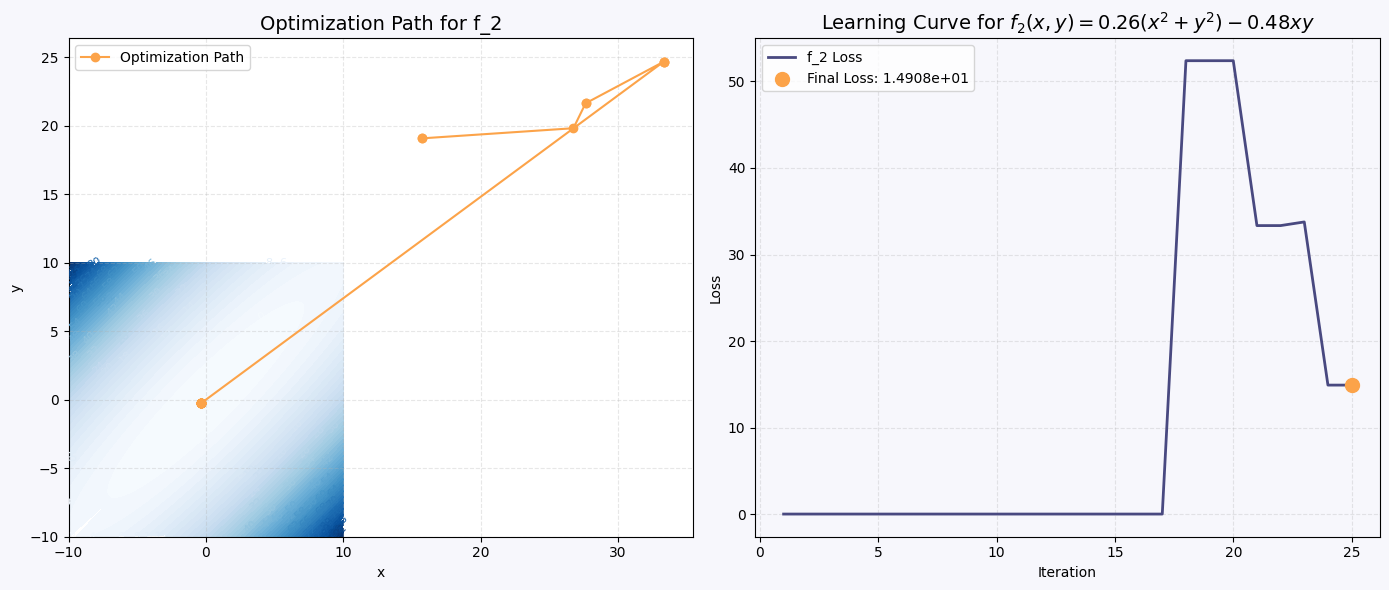

In [42]:
contour_and_learning(sa_opt)

b) Para los mejores valores encontrados, en cada función, por un máximo de 25 iteraciones (para el algoritmo del descenso del gradiente, y el descenso del gradiente adaptativo):

1.  Ejecute el algoritmo 10 corridas diferentes, y documente en una tabla la cantidad de iteraciones para converger a el o los puntos mínimos (indique si convergió). Los 10 puntos iniciales escogidos deben preservarse para todos los algoritmos a probar (deben ser los mismos que el descenso del gradiente y el descenso del gradiente adaptativo).

2. Muestre el valor promedio de la función minimizada para las 10 corridas, y la cantidad de iteraciones promedio en converger.

c) Muestre los puntos visitados del algoritmo para la mejor corrida (convergencia más rápida) para cada función. Para ello, use el gráfico de las curvas de nivel. Además, para tales corridas, grafique la curva de aprendizaje.

d) ¿Cómo podría mezclar el algoritmo del descenso del gradiente con el algoritmo de simulated annealing? ¿Qué beneficios tendría el hacerlo?

# FIN

In [ ]:
print("Code ends here")